# Vector embedding-based change detection -- Turkey earthquake 2023

In [1]:
!pip install pystac_client==0.6.1 stackstac==0.4.4

  Obtaining dependency information for stackstac==0.4.4 from https://files.pythonhosted.org/packages/81/22/3bb47276aa898638fcaf24bd73db6acc8249cfaccb6b1021e579045c1868/stackstac-0.4.4-py3-none-any.whl.metadata
  Obtaining dependency information for pystac>=1.7.0 from https://files.pythonhosted.org/packages/d2/35/efb3ada4f8db776144d786338a41d38e5128f2c1e4a86b681c658fe1151e/pystac-1.8.3-py3-none-any.whl.metadata
  Obtaining dependency information for dask[array]>=2022.1.1 from https://files.pythonhosted.org/packages/f4/b9/ea749b059b5e5eab6231fcd65b3680551a65392c9a37352ddffc17ce8616/dask-2023.8.1-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec>=2021.09.0 from https://files.pythonhosted.org/packages/e3/bd/4c0a4619494188a9db5d77e2100ab7d544a42e76b2447869d8e124e981d8/fsspec-2023.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-metadata>=4.13.0 from https://files.pythonhosted.org/packages/cc/37/db7ba97e676af155f5fcb1a35466f446eadc9104e25b8

---

In [2]:
import gc
from time import perf_counter

from rastervision.core.box import Box
from rastervision.core.data import (
    MinMaxTransformer, RasterioCRSTransformer, 
    StatsTransformer, XarraySource)
from rastervision.core.data.raster_source import XarraySource

from rastervision.pipeline.file_system.utils import download_if_needed, json_to_file, file_to_json
from rastervision.core.data.utils import ensure_json_serializable
from rastervision.core import RasterStats
from rastervision.core.data import Scene
from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset)

import math
from tqdm.auto import tqdm
import numpy as np
from shapely.geometry import mapping
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
import albumentations as A

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import seaborn as sns
sns.reset_defaults()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

## Get time-series of Sentinel-2 images from STAC API

In [5]:
import pystac_client
import stackstac

Antakya, Turkey

In [6]:
bbox = Box(ymin=36.218166, xmin=36.139989, ymax=36.190802, xmax=36.167133).normalize()
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)
bbox

Box(ymin=36.190802, xmin=36.139989, ymax=36.218166, xmax=36.167133)

In [8]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)

items = catalog.search(
    intersects=bbox_geometry,
    collections=["sentinel-2-l2a"],
    datetime="2017-01-01/2023-12-31",
    # datetime="2022-01-01/2023-12-31",
    query={"eo:cloud_cover": {"lt": 5}},
).item_collection()
len(items)

278

In [9]:
stack = stackstac.stack(items, epsg=32637)
stack

<xarray.DataArray 'stackstac-3bbbcd508c07ddc2cba3c3a02f64ed14' (time: 278,
                                                                band: 32,
                                                                y: 11646,
                                                                x: 15044)>
dask.array<fetch_raster_window, shape=(278, 32, 11646, 15044), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-07-05...
    id                                       (time) <U24 'S2B_37SBA_20170705_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 1.593e+05 ... 3.098e+05
  * y                                        (y) float64 4.104e+06 ... 3.988e+06
    s2:vegetation_percentage                 (time) float64 25.21 25.9 ... 26.7
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32637
Attributes:
    spec:        RasterSpec(epsg=32637, bounds=(159340.0, 3987810.0, 309780.0...
    crs:         epsg:32637
    transform:   | 10.00, 0.00, 159340.00|\n| 0.00,-10.00, 4104270.00|\n| 0.0...
    resolution:  10.0

### Convert to a Raster Vision `RasterSource`

In [10]:
data_array = stack
data_array = data_array.sel(
    band=[
        'coastal', # B01
        'blue', # B02
        'green', # B03
        'red', # B04
        'rededge1', # B05
        'rededge2', # B06
        'rededge3', # B07
        'nir', # B08
        'nir08', # B8A
        'nir09', # B09
        'swir16', # ???
        'swir16', # B11
        'swir22', # B12
    ])

### Create the `RasterSource`

In [11]:
crs_transformer = RasterioCRSTransformer(
    transform=stack.transform, image_crs=stack.crs)

In [12]:
xmin_px, ymin_px = crs_transformer.map_to_pixel((bbox.xmin, bbox.ymin))
valid_ts, _ = np.where(~np.isnan(data_array.isel(x=xmin_px, y=ymin_px, band=[0]).to_numpy()))
data_array = data_array.isel(time=valid_ts)
data_array

<xarray.DataArray 'stackstac-3bbbcd508c07ddc2cba3c3a02f64ed14' (time: 278,
                                                                band: 13,
                                                                y: 11646,
                                                                x: 15044)>
dask.array<getitem, shape=(278, 13, 11646, 15044), dtype=float64, chunksize=(1, 2, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2017-07-05...
    id                                       (time) <U24 'S2B_37SBA_20170705_...
  * band                                     (band) <U12 'coastal' ... 'swir22'
  * x                                        (x) float64 1.593e+05 ... 3.098e+05
  * y                                        (y) float64 4.104e+06 ... 3.988e+06
    s2:vegetation_percentage                 (time) float64 25.21 25.9 ... 26.7
    ...                                       ...
    raster:bands                             (band) object None None ... None
    gsd                                      (band) object 60 10 10 ... 20 20 20
    common_name                              (band) object 'coastal' ... 'swi...
    center_wavelength                        (band) object 0.443 0.49 ... 2.19
    full_width_half_max                      (band) object 0.027 0.098 ... 0.242
    epsg                                     int64 32637
Attributes:
    spec:        RasterSpec(epsg=32637, bounds=(159340.0, 3987810.0, 309780.0...
    crs:         epsg:32637
    transform:   | 10.00, 0.00, 159340.00|\n| 0.00,-10.00, 4104270.00|\n| 0.0...
    resolution:  10.0

In [82]:
# means = np.array([756.4, 889.6, 1151.7, 1307.6, 1637.6, 2212.6, 2442.0, 2538.9, 2602.9, 2666.8, 2388.8, 2388.8, 1821.5])
# stds = np.array([1111.4, 1159.1, 1188.1, 1375.2, 1376.6, 1358.6, 1418.4, 1476.4, 1439.9, 1582.1, 1460.7, 1460.7, 1352.2])
# stats = RasterStats(means, stds)
# stats.save('SSL4EO_stats.json')

In [13]:
stats_tf = StatsTransformer.from_stats_json('SSL4EO_stats.json')

In [14]:
raster_source = XarraySource(
    data_array,
    crs_transformer=crs_transformer,
    raster_transformers=[stats_tf],
    channel_order=list(range(len(data_array.band))),
    temporal=True
)
raster_source.shape

(278, 11646, 15044, 13)

In [15]:
T = raster_source.shape[0]
t_strs = np.array([str(_t.date()) for _t in raster_source.data_array.time.to_series().to_list()])

In [86]:
window = raster_source.crs_transformer.map_to_pixel(bbox).normalize()#.pad(50, 51, 51, 51)

  0%|          | 0/69 [00:00<?, ?it/s]

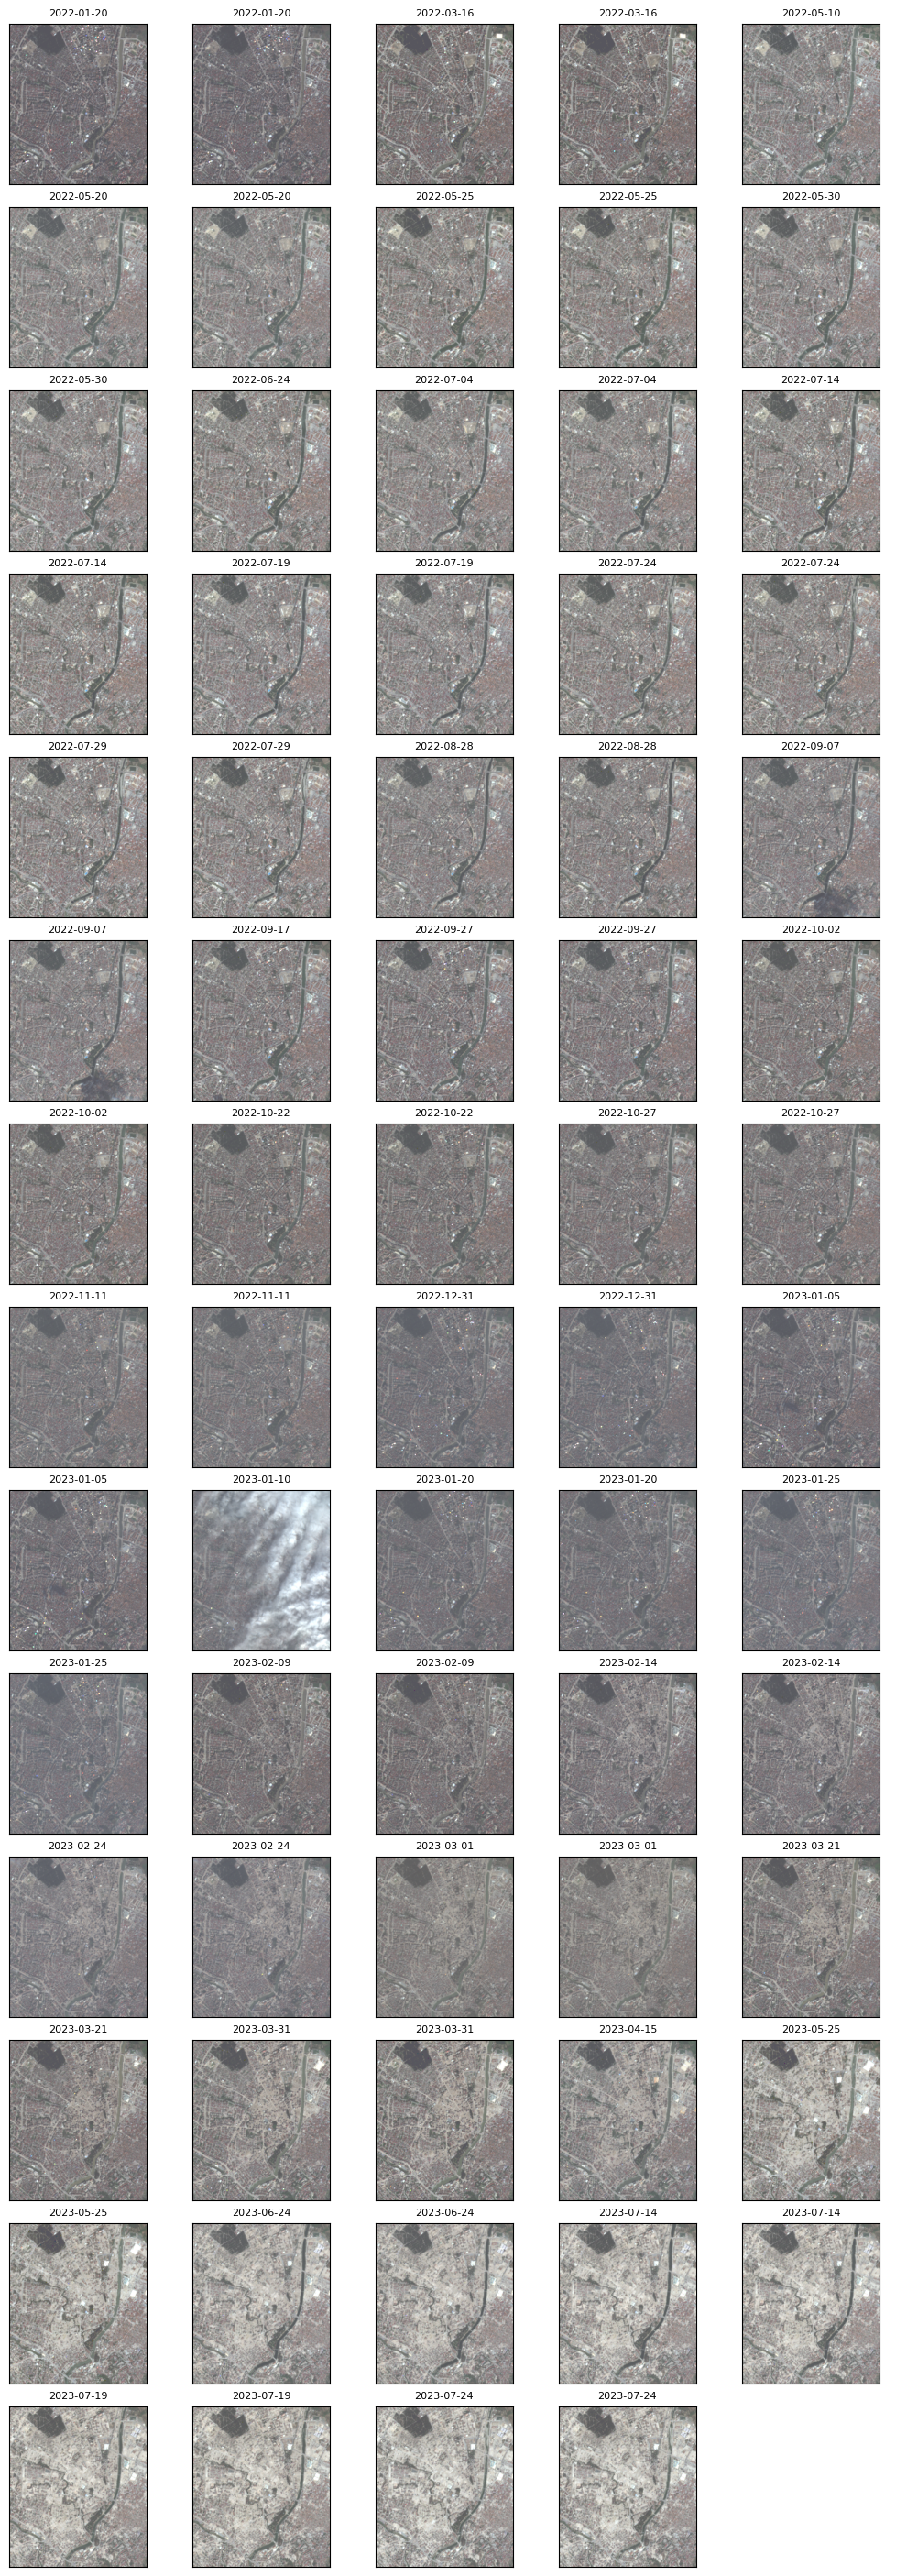

In [87]:
plt.close('all')

skip = 1
ts = range(0, T, skip)
t_strs_ = t_strs[::skip]

ncols = 5
nrows = int(math.ceil(len(ts) / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 2, nrows * 2), constrained_layout=True)
with tqdm(zip(ts, t_strs_, axs.flat), total=len(ts)) as bar:
    for t, t_str_t, ax in bar:
        chip_t = raster_source.get_chip(window, bands=[3, 2, 1], time=t)
        ax.imshow(chip_t)
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False, labeltop=False)
        ax.set_title(t_str_t, fontsize=8)
if t < len(axs.flat) - 1:
    for ax in axs.flat[t + 1:]:
        ax.axis('off')
plt.show()

In [174]:
skip = 1
ts = range(0, T, skip)
t_strs_ = t_strs[::skip]

chips = []
with tqdm(zip(ts, t_strs_), total=len(ts)) as bar:
    for t, t_str_t in bar:
        chip_t = raster_source.get_chip(window, bands=[3, 2, 1], time=t)
        chips.append(chip_t)
chips = np.stack(chips)

  0%|          | 0/278 [00:00<?, ?it/s]

In [176]:
assert len(chips) == len(t_strs)
np.save('chips_tr_earthquake.npy', chips)

---

## Generate embeddings

### Get model

https://github.com/zhu-xlab/SSL4EO-S12

MoCo	ResNet18	S2-L1C 13 bands

In [16]:
from torch import nn
from torchvision.models import resnet18
from rastervision.pytorch_learner.utils import adjust_conv_channels

In [17]:
sd = torch.load('./B13_rn18_moco_0099_ckpt.pth')
sd_encoder_q = {k: v for k, v in sd['state_dict'].items() if (k.startswith('module.encoder_q') and not '.fc.' in k)}
sd_encoder_q_no_prefix = {k.replace('module.encoder_q.', ''): v for k, v in sd_encoder_q.items()}

In [18]:
model = resnet18(weights=None)
model.fc = nn.Identity()
model.conv1 = adjust_conv_channels(model.conv1, 13, pretrained=False)
model.load_state_dict(sd_encoder_q_no_prefix)
model = model.to(device=DEVICE)
model = model.eval()

---

### Run inference

In [19]:
def get_embedding(model: nn.Module, x: np.ndarray) -> np.ndarray:
    x = torch.from_numpy(x).float()
    x = x.permute(2, 0, 1).unsqueeze(0)
    x = x.to(device=DEVICE)
    out = model(x)
    out = out.cpu().numpy()
    return out

In [20]:
window = raster_source.crs_transformer.map_to_pixel(bbox).normalize()#.pad(50, 51, 51, 51)

In [21]:
skip = 1
ts = range(0, T, skip)
t_strs_ = t_strs[::skip]

embeddings = []
with tqdm(zip(ts, t_strs_), total=len(ts)) as bar, torch.inference_mode():
    for t, t_str in bar:
        chip_t = raster_source.get_chip(window, time=t)
        embedding_t = get_embedding(model, chip_t).squeeze()
        year, _, _ = t_str.split('-')
        year = int(year)
        embeddings.append(embedding_t)

embeddings = np.stack(embeddings)
embeddings.shape

  0%|          | 0/278 [00:00<?, ?it/s]

(278, 512)

In [22]:
embeddings_json = dict(
    embeddings=embeddings, 
    t_strs=t_strs, 
)
json_to_file(ensure_json_serializable(embeddings_json), 'seasonal_variation_embeddings_tr_earthquake.json')

---

## Analysis

In [156]:
embeddings_json = file_to_json('seasonal_variation_embeddings_tr_earthquake.json')
embeddings = np.array(embeddings_json['embeddings'])
t_strs = np.array(embeddings_json['t_strs'])

In [101]:
mask = (t_strs != '2021-09-27')
embeddings = embeddings[mask]
t_strs = t_strs[mask]

In [102]:
inds_pre_2023 = np.where([s < '2023' for s in t_strs])[0]
inds_2023 = np.where([s.startswith('2023') for s in t_strs])[0]
inds_post_eq = np.where([s >= '2023-02-06' for s in t_strs])[0]

t_strs_pre_2023 = t_strs[inds_pre_2023]
embeddings_pre_2023 = embeddings[inds_pre_2023]

t_strs_2023 = t_strs[inds_2023]
embeddings_2023 = embeddings[inds_2023]

t_strs_post_eq = t_strs[inds_post_eq]
embeddings_post_eq = embeddings[inds_post_eq]

In [103]:
from datetime import datetime

t_doy = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs])
t_doy_pre_2023 = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_pre_2023])
t_doy_2023 = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_2023])
t_doy_post_eq = np.array([datetime.strptime(t_str, '%Y-%m-%d').timetuple().tm_yday for t_str in t_strs_post_eq])

In [104]:
def to_t_day(t_str):
    t_tuple = datetime.strptime(t_str, '%Y-%m-%d').timetuple()
    return (t_tuple.tm_year + np.clip(t_tuple.tm_yday / 365, 0, 1))

In [105]:
t_day = np.array([to_t_day(t_str) for t_str in t_strs])
t_day_pre_2023 = np.array([to_t_day(t_str) for t_str in t_strs_pre_2023])
t_day_2023 = np.array([to_t_day(t_str) for t_str in t_strs_2023])
t_day_post_eq = np.array([to_t_day(t_str) for t_str in t_strs_post_eq])

In [106]:
mu = embeddings_pre_2023.mean(axis=0)
sigma = embeddings_pre_2023.std(axis=0)

In [107]:
z = np.clip(np.nan_to_num((embeddings - mu) / sigma), -6, 6)

---

### Statistical model

In [33]:
from sklearn.decomposition import PCA, IncrementalPCA, FastICA, FactorAnalysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


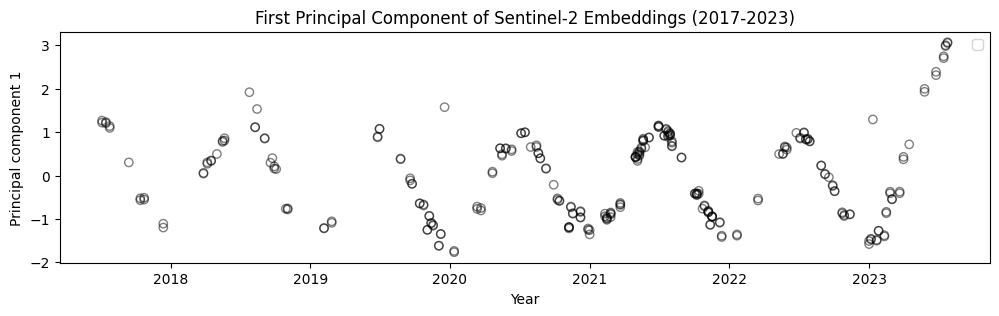

In [108]:
pca = PCA(whiten=True)
# pca = FactorAnalysis()
pca.fit(embeddings)
pc = 0

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(12, 3), squeeze=True)

pca_emb = pca.transform(embeddings)
x = t_day
ax.scatter(x, pca_emb[:, pc], ec='k', fc='none', alpha=0.5)
# ax.plot(x, pca_emb[:, pc], c='k', alpha=0.25)

# ax.legend(loc='upper left', framealpha=0.1)
ax.legend()
# ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Year')
# ax.set_xlim((2017, 2024))
ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

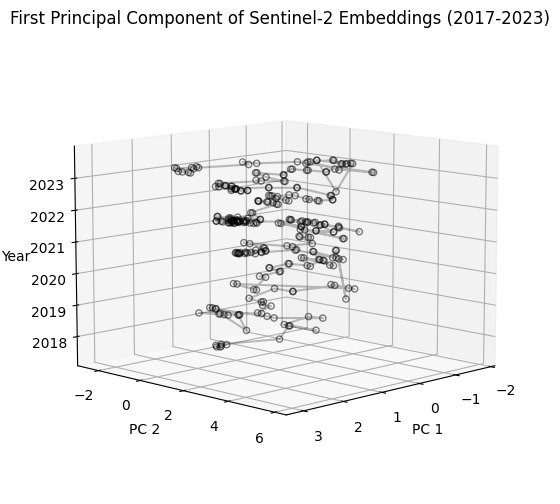

In [109]:
pca = PCA(whiten=True)
# pca = FactorAnalysis()
pca.fit(embeddings)
pc = 0

plt.close('all')
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(projection='3d')

pca_emb = pca.transform(embeddings)
x = t_day
ax.scatter(x, pca_emb[:, pc], zs=pca_emb[:, pc+1], ec='k', fc='none', alpha=0.5)
ax.plot(x, pca_emb[:, pc], zs=pca_emb[:, pc+1], c='k', alpha=0.25)

# ax.legend(loc='upper left', framealpha=0.1)
# ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Year')
# ax.set_xlim((2017, 2024))
ax.set_ylabel(f'PC 1')
ax.set_zlabel(f'PC 2')
ax.view_init(elev=10, azim=45, roll=0, vertical_axis='x')

plt.show()

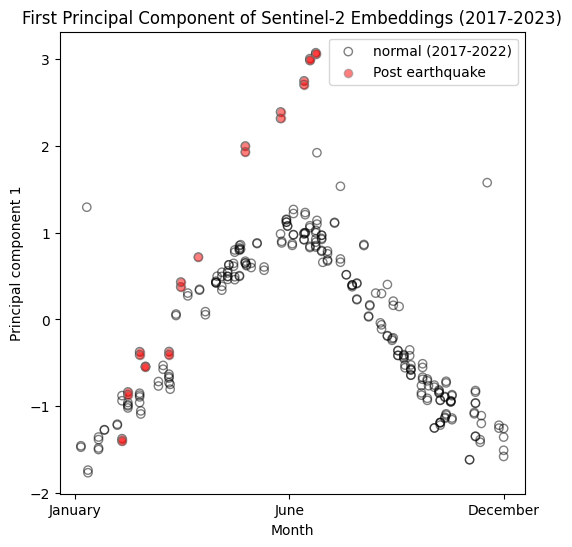

In [110]:
pca = PCA(whiten=True)
# pca = FactorAnalysis()
pca.fit(embeddings)
pc = 0

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal (2017-2022)')

pca_emb = pca.transform(embeddings_post_eq)
x = np.clip(t_doy_post_eq / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='gray', fc='r', alpha=0.5, label='Post earthquake')

ax.legend()
ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

In [26]:
fig.savefig('embedding_seasonal_variation_tr_earthquake.png', bbox_inches='tight', pad_inches=0.2)

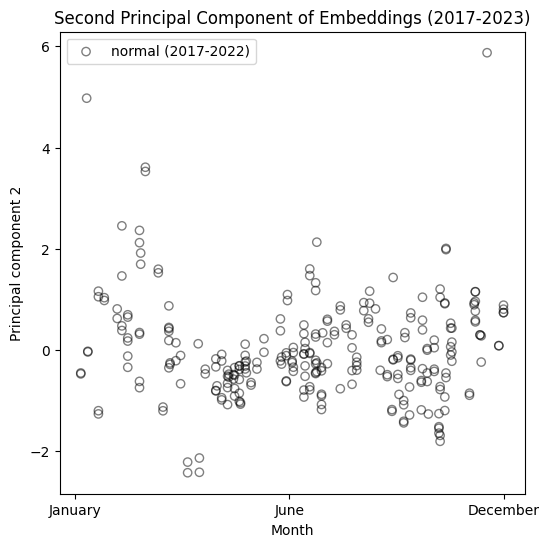

In [111]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

pc = 1

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
ax.scatter(x, pca_emb[:, pc], ec='k', fc='none', alpha=0.5, label='normal (2017-2022)')

ax.legend()
ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('Second Principal Component of Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel(f'Principal component {pc + 1}')

plt.show()

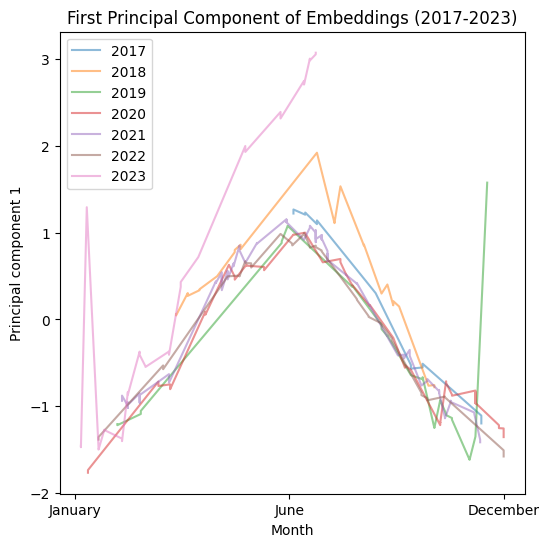

In [113]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)

cmap = plt.get_cmap('tab10')
for i, year in enumerate(range(2017, 2024)):
    year_inds = np.where([t_str.startswith(str(year)) for t_str in t_strs])[0]
    pca_emb = pca.transform(embeddings[year_inds])
    x = np.clip(t_doy[year_inds] / 365, 0, 1)
    ax.plot(x, pca_emb[:, 0], c=cmap(i), alpha=0.5, label=f'{year}')

ax.legend()
ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel('Principal component 1')

plt.show()

---

In [41]:
def t_to_feats(t):
    feat_1 = np.sin(t * np.pi * 2)
    feat_2 = np.cos(t * np.pi * 2)
    return np.stack([feat_1, feat_2], axis=1)

In [42]:
from sklearn.linear_model import (
    LinearRegression, Ridge, BayesianRidge, HuberRegressor, RANSACRegressor,
    TheilSenRegressor, )

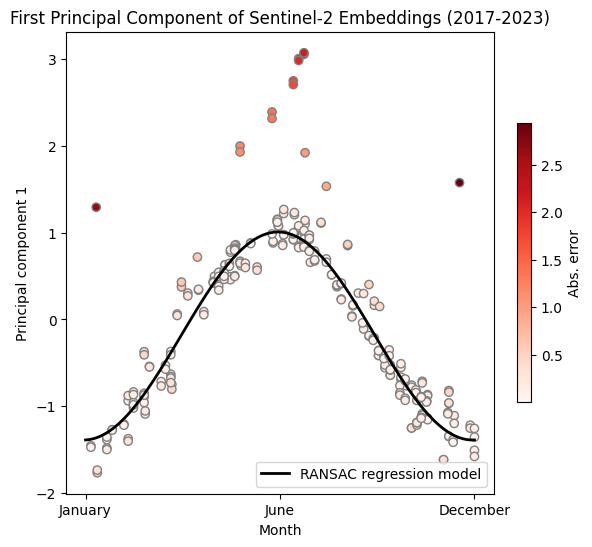

In [145]:
pca = PCA(whiten=True)
pca.fit(embeddings)
pc = 0

lr = RANSACRegressor()
Y = pca.transform(embeddings)[:, pc]
t = np.clip(t_doy / 365, 0, 1)
X = t_to_feats(t)
lr.fit(X, Y)

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)
cmap = plt.get_cmap('Reds')

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
# error = np.sqrt((lr.predict(t_to_feats(x)) - pca_emb[:, pc])**2)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
norm = Normalize(error.min(), error.max())
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)

t = np.linspace(0, 1, 100)
x = t_to_feats(t)
y_pred = lr.predict(x)
ax.plot(t, y_pred, lw=2, c='k', label='RANSAC regression model')
ax.legend()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, fraction=0.03, label='Abs. error')

ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('First Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel('Principal component 1')
plt.show()

In [116]:
np.where(error > 2)[0]

array([ 68, 242, 266, 267, 268, 269])

  0%|          | 0/5 [00:00<?, ?it/s]

[123.87232935 124.87819143 125.19845636 128.60734697 126.65340241
 117.92349909 114.55485525 112.95215522 111.68348734 111.93382117
 123.16765036 123.16765036 131.43081669]
[124.31366841 125.18641171 125.37860538 128.69049781 126.70935263
 117.94828277 114.57603354 112.96243724 111.69105865 111.94850977
 123.1270297  123.1270297  131.41767706]
[122.02694691 127.43735979 126.88895417 130.38103568 128.45761671
 119.00389916 117.1423459  113.83680964 113.39748691 112.79755101
 124.77686679 124.77686679 135.25610245]
[122.47473561 127.72011537 127.06595182 130.45955293 128.49675515
 119.05126322 117.18443542 113.8745994  113.41280312 112.85304722
 124.78614731 124.78614731 135.27602553]
[128.95521312 127.81269362 125.57990599 127.64384147 125.28359684
 114.83650251 111.02322134 108.80229142 107.89222572 108.18137752
 119.27801517 119.27801517 127.68221878]


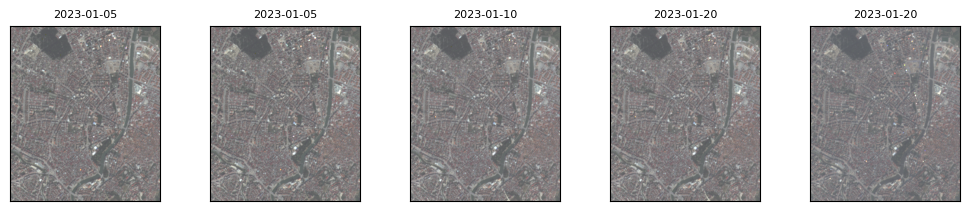

In [121]:
plt.close('all')

skip = 1
ts = [240, 241, 242, 243, 244]
t_strs_ = t_strs[ts]

ncols = 5
nrows = int(math.ceil(len(ts) / ncols))
fig, axs = plt.subplots(
    nrows, ncols, figsize=(ncols * 2, nrows * 2), constrained_layout=True)
with tqdm(zip(ts, t_strs_, axs.flat), total=len(ts)) as bar:
    for i, (t, t_str_t, ax) in enumerate(bar):
        # chip_t = raster_source.get_chip(window, bands=[3, 2, 1], time=t)
        chip_t = raster_source.get_chip(window, time=t)
        print(chip_t.reshape(-1, chip_t.shape[-1]).mean(axis=0))
        chip_t = chip_t[..., [3, 2, 1]]
        ax.imshow(chip_t)
        ax.tick_params(top=False, bottom=False, left=False, right=False,
                    labelleft=False, labelbottom=False, labeltop=False)
        ax.set_title(t_str_t, fontsize=8)

if i < len(axs.flat) - 1:
    for ax in axs.flat[i + 1:]:
        ax.axis('off')
plt.show()

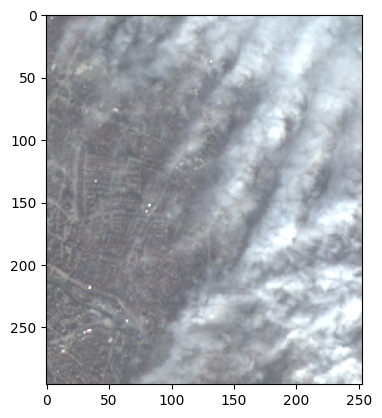

In [172]:
plt.imshow(chip_t_250[..., [3, 2, 1]])
plt.show()

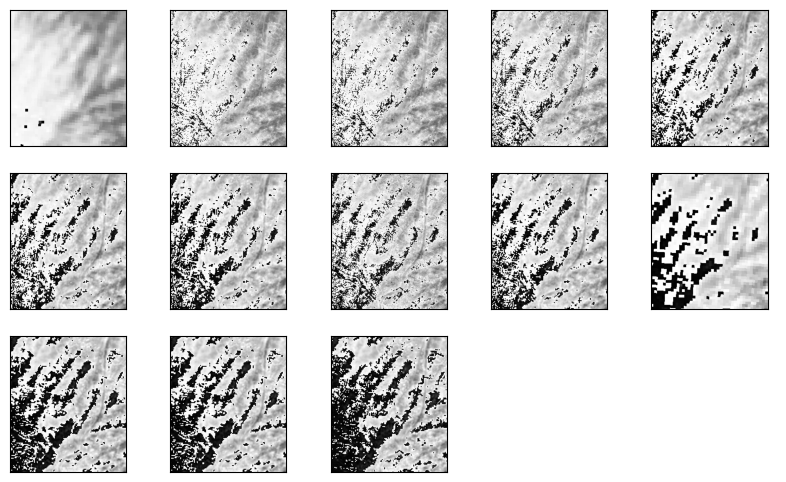

In [171]:
# chip_t_249 = raster_source.get_chip(window, time=249)
# chip_t_250 = raster_source.get_chip(window, time=250)
chip_t = np.abs(chip_t_249 - chip_t_250)
chip_t = MinMaxTransformer().transform(chip_t)
fig, axs = plt.subplots(3, 5, figsize=(10, 6))
for i, (band, ax) in enumerate(zip(chip_t.transpose(2, 0, 1), axs.flat)):
    ax.imshow(band, cmap='gray')
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)
if i < len(axs.flat) - 1:
    for ax in axs.flat[i + 1:]:
        ax.axis('off')
plt.show()

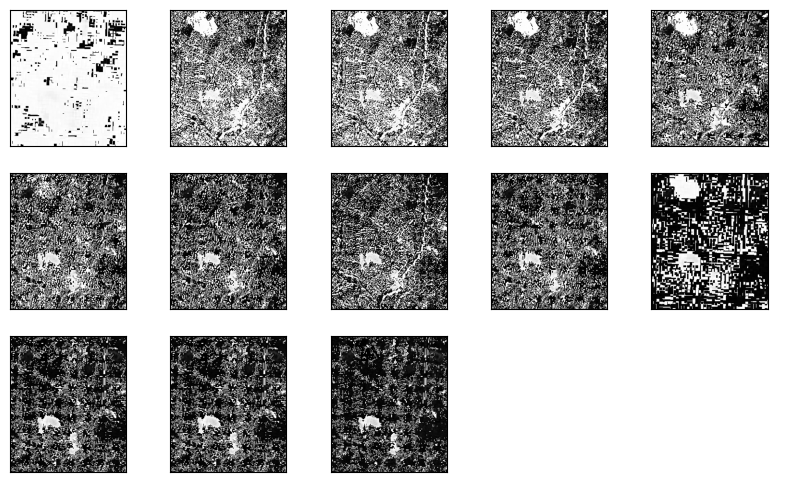

In [170]:
# chip_t_249 = raster_source.get_chip(window, time=249)
# chip_t_251 = raster_source.get_chip(window, time=251)
chip_t = np.abs(chip_t_249 - chip_t_251)
chip_t = MinMaxTransformer().transform(chip_t)
fig, axs = plt.subplots(3, 5, figsize=(10, 6))
for i, (band, ax) in enumerate(zip(chip_t.transpose(2, 0, 1), axs.flat)):
    ax.imshow(band, cmap='gray')
    ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False, labeltop=False)
if i < len(axs.flat) - 1:
    for ax in axs.flat[i + 1:]:
        ax.axis('off')
plt.show()

In [167]:
chip_t_249 = raster_source.get_chip(window, time=249)
chip_t_250 = raster_source.get_chip(window, time=250)
chip_t_251 = raster_source.get_chip(window, time=251)

In [168]:
with torch.inference_mode():
    e_249 = get_embedding(model, chip_t_249).squeeze()
    e_250 = get_embedding(model, chip_t_250).squeeze()
    e_251 = get_embedding(model, chip_t_251).squeeze()
np.linalg.norm(e_249 - e_250)

19.290451

In [169]:
np.testing.assert_allclose(embeddings[250], e_250)

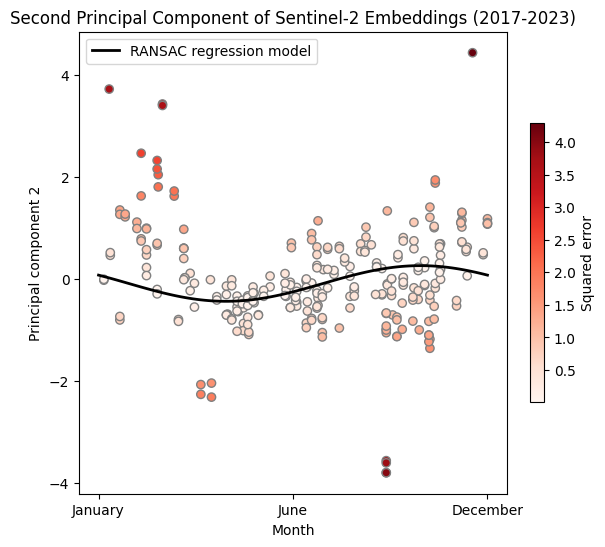

In [44]:
pca = PCA(whiten=True)
pca.fit(embeddings)
pc = 1

lr = RANSACRegressor()
Y = pca.transform(embeddings)[:, pc]
t = np.clip(t_doy / 365, 0, 1)
X = t_to_feats(t)
lr.fit(X, Y)

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6, 6), squeeze=True)
cmap = plt.get_cmap('Reds')

pca_emb = pca.transform(embeddings)
x = np.clip(t_doy / 365, 0, 1)
# error = np.sqrt((lr.predict(t_to_feats(x)) - pca_emb[:, pc])**2)
error = np.abs(lr.predict(t_to_feats(x)) - pca_emb[:, pc])
norm = Normalize(error.min(), error.max())
cols = cmap(norm(error))
ax.scatter(x, pca_emb[:, pc], c=cols, ec='gray', alpha=1)

t = np.linspace(0, 1, 100)
x = t_to_feats(t)
y_pred = lr.predict(x)
ax.plot(t, y_pred, lw=2, c='k', label='RANSAC regression model')
ax.legend()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, fraction=0.03, label='Squared error')

ax.set_xticks([0, 0.5, 1], ['January', 'June', 'December'])
ax.set_title('Second Principal Component of Sentinel-2 Embeddings (2017-2023)')
ax.set_xlabel('Month')
ax.set_ylabel(f'Principal component {pc + 1}')
plt.show()